# Limpieza y EDA

Objetivo: normalizar columnas clave, crear features de fecha, imputar `State`/`ZIP code`,
analizar valores faltantes y explorar variables con foco en el target **Timely response?**.

In [13]:

# --- Bootstrap del proyecto ---
import sys, pathlib, sklearn, numpy as np, pandas as pd, matplotlib
ROOT = pathlib.Path.cwd()
for cand in [ROOT] + list(ROOT.parents):
    if (cand / "src").is_dir():
        if str(cand) not in sys.path: sys.path.insert(0, str(cand))
        if str(cand / "src") not in sys.path: sys.path.insert(0, str(cand / "src"))
        break
print("Repo root:", cand)
print("sklearn:", sklearn.__version__, "| numpy:", np.__version__, "| pandas:", pd.__version__, "| matplotlib:", matplotlib.__version__)
import src.runtime_transforms  # asegura FunctionTransformer


Repo root: c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN
sklearn: 1.5.1 | numpy: 2.1.3 | pandas: 2.3.2 | matplotlib: 3.10.6


In [14]:

from pathlib import Path
from src.preprocessing import yes_no_to_int, yn_to_bool, date_diff_days

USE_SAMPLE = False  # cambia a False para tu CSV real
SAMPLE = Path("data/samples/synthetic_sample.csv")
USER_CSV = Path("../data/quejas-clientes.csv")

CSV_PATH = SAMPLE if USE_SAMPLE else USER_CSV
print("Usando CSV:", CSV_PATH.resolve())
df = pd.read_csv(CSV_PATH, low_memory=False)
df.head(3)


Usando CSV: C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\data\quejas-clientes.csv


,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
0,0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,"Premium Asset Services, LLC",In progress,Yes,NaN
1,1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN
2,2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,RBS Citizens,Closed with explanation,Yes,Yes


In [15]:
from skrub import TableReport
#from skrub import TableReport
TableReport(df)

Processing column  14 / 14


,,,,,,,,,,,,,,


In [16]:
## 3. Valores faltantes
faltantes = df.isna().sum().rename("faltantes")
faltantes_porc = df.isna().mean().rename("faltantes_porc") # porcentajes
faltantes_df = pd.concat([faltantes, faltantes_porc], axis=1).sort_values("faltantes", ascending=False)
faltantes_df.head(30)
df = df.drop(columns=["Unnamed: 0"])


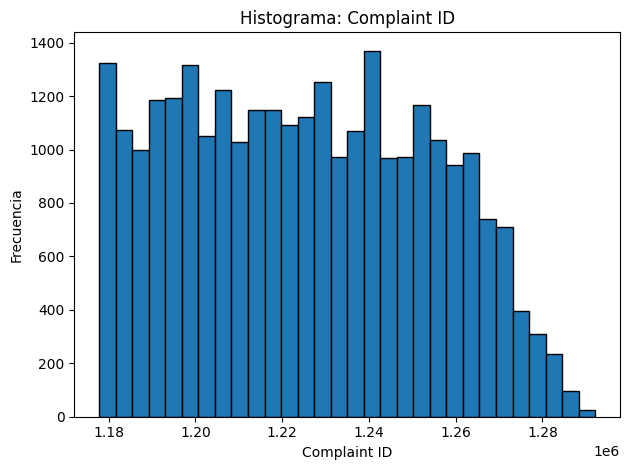

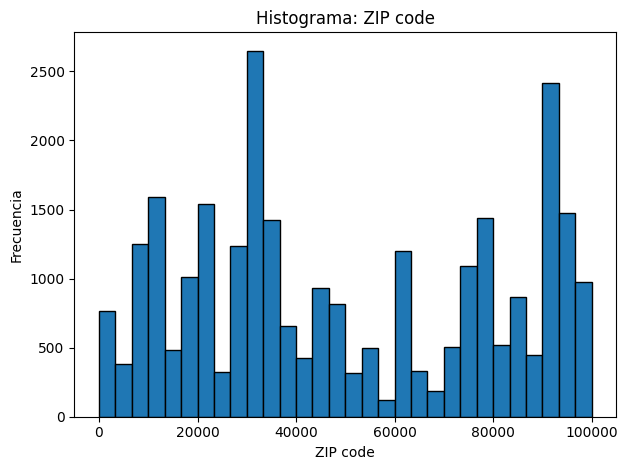

In [17]:
import matplotlib.pyplot as plt 
## 4. Variables numéricas: descriptivos e histogramas
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
desc = df[num_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T if num_cols else pd.DataFrame()
desc
for c in num_cols:
    plt.figure()
    df[c].dropna().plot(kind="hist", bins=30, edgecolor="black")
    plt.title(f"Histograma: {c}")
    plt.xlabel(c); plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

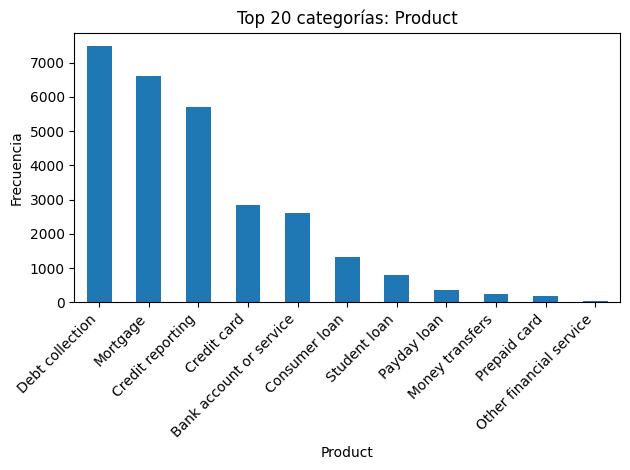

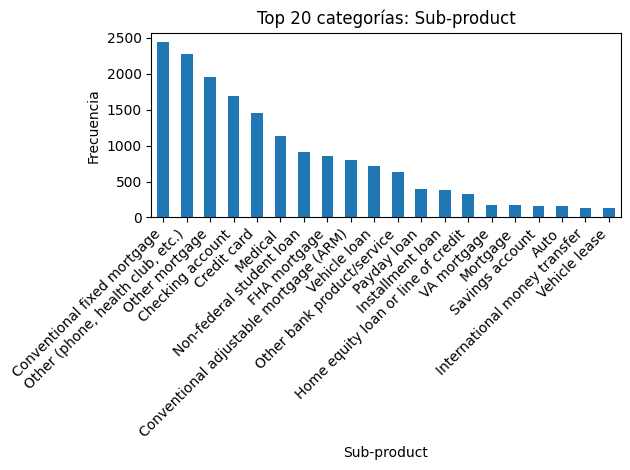

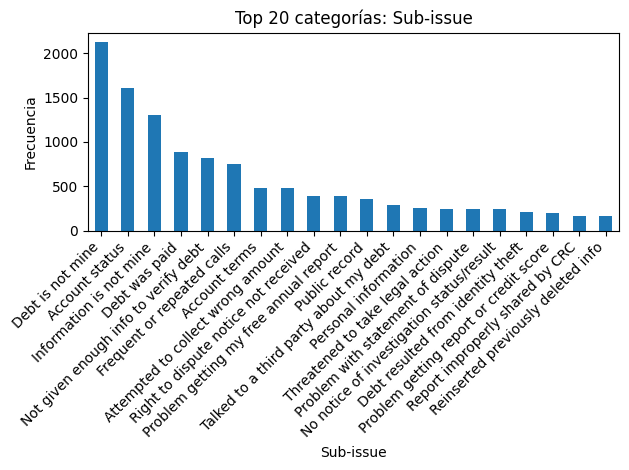

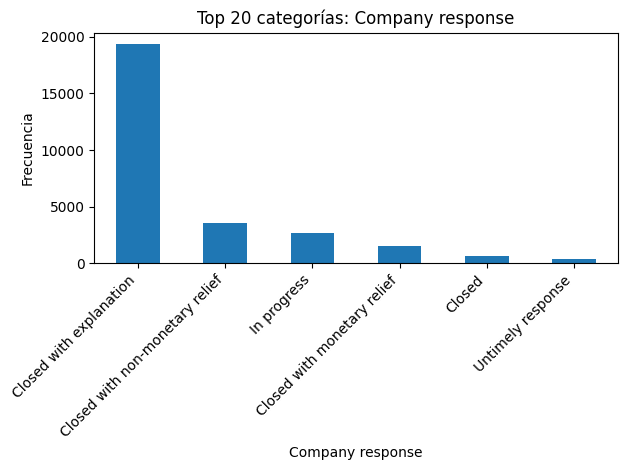

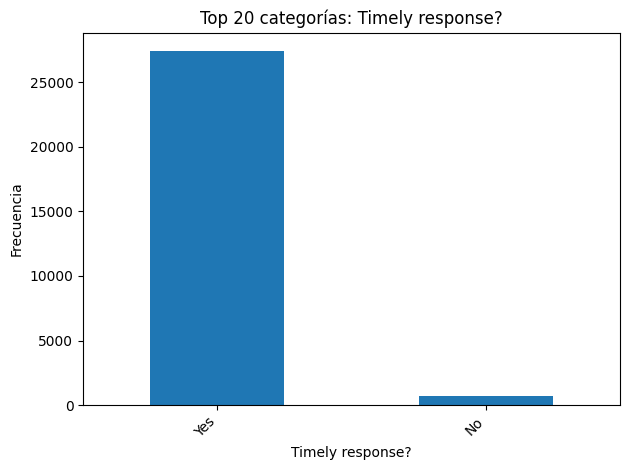

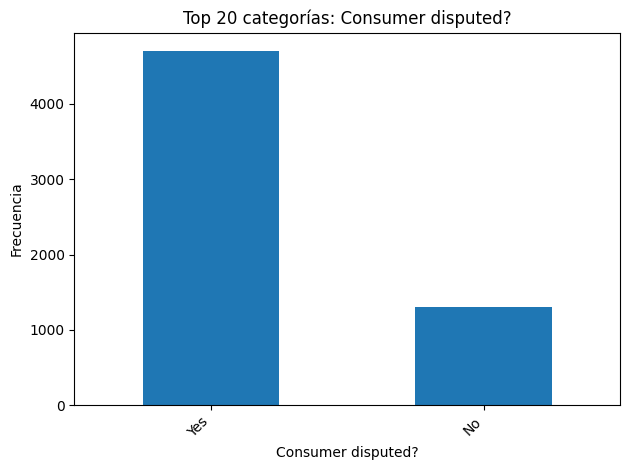

In [18]:
## 5. Variables categóricas: cardinalidad y barras (Top 20)
#cat_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if not df[c].dtype in ['int64', 'float64']]

rows = []
# determinamos la cadena de mayor frecuencia en cada categoría
for c in cat_cols:
    cadena = df[c].astype("string")
    n_unique = cadena.nunique(dropna=True)
    mode = cadena.mode(dropna=True)
    mode_val = None if mode.empty else mode.iloc[0]
    rows.append({"column": c, "n_unique": int(n_unique), "mode": mode_val})

pd.DataFrame(rows).sort_values("n_unique", ascending=False)
# Histograma de frecuencias
for c in cat_cols:
    s = df[c].astype("string")
    n_unique = int(s.nunique(dropna=True))
    if n_unique == 0:
        continue
    top = s.value_counts(dropna=True).head(20)
    if n_unique <= 50:  # evita gráficos poco legibles
        plt.figure()
        top.plot(kind="bar")
        plt.title(f"Top 20 categorías: {c}")
        plt.xlabel(c); plt.ylabel("Frecuencia")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


En este gráfico se puede observa el desbalance de clases en la variable objetivo "Conusmer disputed". Esto puede ser un problema a la hora de la modelización.


,Complaint ID,ZIP code
Complaint ID,1.000000,0.001352
ZIP code,0.001352,1.000000


,Complaint ID,ZIP code
Complaint ID,1.000000,0.002656
ZIP code,0.002656,1.000000


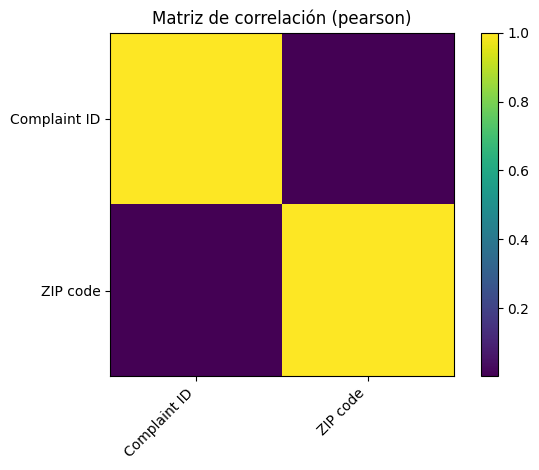

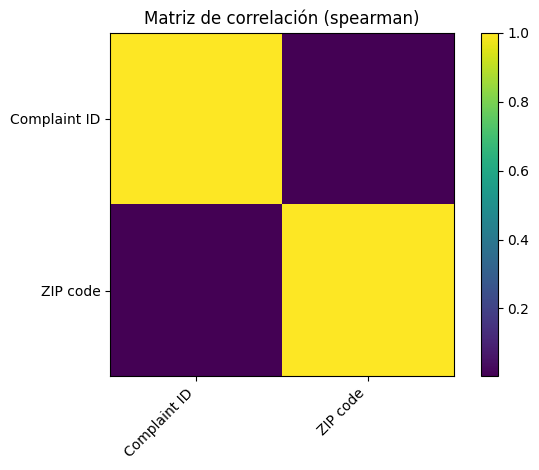

In [19]:
## 6. Correlaciones (Pearson y Spearman)
if len(num_cols) >= 2:
    corr_p = df[num_cols].corr(method="pearson")
    corr_s = df[num_cols].corr(method="spearman")
    display(corr_p)
    display(corr_s)

    for name, mat in [("pearson", corr_p), ("spearman", corr_s)]:
        plt.figure()
        plt.imshow(mat, interpolation="nearest")
        plt.title(f"Matriz de correlación ({name})")
        plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
        plt.yticks(range(len(num_cols)), num_cols)
        plt.colorbar()
        plt.tight_layout()
        plt.show()
else:
    print("No hay suficientes variables numéricas para correlaciones.")

In [20]:
## 7. Outliers por IQR
rows = []
for c in num_cols:
    x = df[c].dropna().astype(float)
    if x.empty:
        rows.append({"column": c, "n_outliers": 0})
        continue
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_out = int(((x < lower) | (x > upper)).sum())
    rows.append({"column": c, "n_outliers": n_out})
pd.DataFrame(rows)
## 8. Columnas de fecha (si existen)
df["Date received"] = pd.to_datetime(df["Date received"], errors="coerce")
df["Date sent to company"] = pd.to_datetime(df["Date sent to company"], errors="coerce")

## 9. Especial: `State` y `ZIP code`
summary = {}
s = df["State"].astype("string")
summary["missing_state"] = int(s.isna().sum())
summary["n_unique_state"] = int(s.nunique(dropna=True))

z = df["ZIP code"].astype("string")
summary["missing_zip"] = int(z.isna().sum())
summary["n_unique_zip"] = int(z.nunique(dropna=True))

summary

{'missing_state': 421,
 'n_unique_state': 59,
 'missing_zip': 280,
 'n_unique_zip': 9868}

### Imputación simple de `State` y `ZIP code`
- Si ambos faltan ⇒ `ZIP code=-9999`, `State='NoI'`
- Si falta `State` pero hay `ZIP` ⇒ asigna estado más común observado para ese ZIP (o ZIP3)
- Si falta `ZIP` pero hay `State` ⇒ asigna ZIP más común observado para ese estado
(Implementación local, sin archivos externos)

In [21]:

import pandas as pd

def impute_state_zip_from_self(df: pd.DataFrame, state_col="State", zip_col="ZIP code",
                               both_missing_zip=-9999, both_missing_state="NoI") -> pd.DataFrame:
    out = df.copy()
    if state_col not in out.columns: out[state_col] = pd.NA
    if zip_col not in out.columns: out[zip_col] = pd.NA
    out[state_col] = out[state_col].astype("string")
    out[zip_col]   = out[zip_col].astype("string")

    def zip3(z):
        if pd.isna(z): return pd.NA
        z = str(z).strip()
        if not z: return pd.NA
        z = "".join(ch for ch in z if ch.isdigit())
        return z[:3] if len(z) >= 3 else pd.NA

    out["_ZIP3"] = out[zip_col].map(zip3)

    map_zip_to_state = out.dropna(subset=[state_col, zip_col]).groupby(zip_col)[state_col]         .agg(lambda s: s.mode().iloc[0] if len(s.mode()) else pd.NA)
    map_zip3_to_state = out.dropna(subset=[state_col, "_ZIP3"]).groupby("_ZIP3")[state_col]         .agg(lambda s: s.mode().iloc[0] if len(s.mode()) else pd.NA)
    map_state_to_zip = out.dropna(subset=[state_col, zip_col]).groupby(state_col)[zip_col]         .agg(lambda s: s.mode().iloc[0] if len(s.mode()) else pd.NA)

    mask = out[state_col].isna() & out[zip_col].notna()
    out.loc[mask, state_col] = out.loc[mask, zip_col].map(map_zip_to_state)

    mask2 = out[state_col].isna() & out["_ZIP3"].notna()
    out.loc[mask2, state_col] = out.loc[mask2, "_ZIP3"].map(map_zip3_to_state)

    mask = out[zip_col].isna() & out[state_col].notna()
    out.loc[mask, zip_col] = out.loc[mask, state_col].map(map_state_to_zip)

    mask = out[zip_col].isna() & out[state_col].isna()
    out.loc[mask, zip_col] = str(both_missing_zip)
    out.loc[mask, state_col] = both_missing_state

    out.drop(columns=["_ZIP3"], inplace=True, errors="ignore")
    return out

df = impute_state_zip_from_self(df, state_col="State", zip_col="ZIP code")
df[["State","ZIP code"]].head(5)


,State,ZIP code
0,TX,76119.0
1,TX,77479.0
2,MA,2127.0
3,CA,92592.0
4,OH,43068.0


### Normalización del target y features de fecha

In [22]:

# Target binario
df["y"] = yes_no_to_int(df.get("Timely response?", pd.Series(pd.NA, index=df.index)))
print("Distribución y (0/1):"); display(df["y"].value_counts(dropna=False))

# Features de fecha
df["days_to_forward"] = date_diff_days(df.get("Date received"), df.get("Date sent to company"))
for col in ["Date received"]:
    dt = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
    df[col+"_year"] = dt.dt.year
    df[col+"_month"] = dt.dt.month
    df[col+"_dow"] = dt.dt.dayofweek

df.head(3)
df.describe(include="all")

Distribución y (0/1):


y
1    27444
0      712
Name: count, dtype: Int64

c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\preprocessing.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d0 = pd.to_datetime(s_start, errors="coerce", infer_datetime_format=True)
c:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\src\preprocessing.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d1 = pd.to_datetime(s_end, errors="coerce", infer_datetime_format=True)
C:\Users\abela\AppData\Local\Temp\ipykernel_11460\1843327843.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed

,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?,y,days_to_forward,Date received_year,Date received_month,Date received_dow
count,2.815600e+04,28156,17582,28154,13211,28155,28156,28156,28156,28156,28156,28156,6006,28156.0,28156.000000,28156.0,28156.000000,28156.000000
unique,NaN,11,42,89,46,60,9869,NaN,NaN,1534,6,2,2,<NA>,NaN,NaN,NaN,NaN
top,NaN,Debt collection,Conventional fixed mortgage,Incorrect information on credit report,Debt is not mine,CA,-9999,NaN,NaN,Equifax,Closed with explanation,Yes,Yes,<NA>,NaN,NaN,NaN,NaN
freq,NaN,7494,2446,4170,2125,3884,154,NaN,NaN,2049,19381,27444,4708,<NA>,NaN,NaN,NaN,NaN
mean,1.225267e+06,NaN,NaN,NaN,NaN,NaN,NaN,2015-02-03 23:08:26.833357056,2015-02-06 22:10:08.609177600,NaN,NaN,NaN,NaN,0.974712,2.959511,2015.0,1.669626,2.360740
min,1.177839e+06,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01 00:00:00,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,0.0,0.000000,2015.0,1.000000,0.000000
25%,1.200523e+06,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-20 00:00:00,2015-01-22 00:00:00,NaN,NaN,NaN,NaN,1.0,0.000000,2015.0,1.000000,1.000000
50%,1.224512e+06,NaN,NaN,NaN,NaN,NaN,NaN,2015-02-04 00:00:00,2015-02-06 00:00:00,NaN,NaN,NaN,NaN,1.0,1.000000,2015.0,2.000000,2.000000
75%,1.248698e+06,NaN,NaN,NaN,NaN,NaN,NaN,2015-02-19 00:00:00,2015-02-24 00:00:00,NaN,NaN,NaN,NaN,1.0,5.000000,2015.0,2.000000,4.000000
max,1.292165e+06,NaN,NaN,NaN,NaN,NaN,NaN,2015-03-19 00:00:00,2015-03-19 00:00:00,NaN,NaN,NaN,NaN,1.0,64.000000,2015.0,3.000000,6.000000


### Faltantes después de la limpieza

In [5]:

missing_after = df.isna().sum().sort_values(ascending=False).to_frame("missing")
missing_after.head(15)


,missing
Consumer disputed?,22150
Sub-issue,14945
Sub-product,10574
Issue,2
State,1
Unnamed: 0,0
Complaint ID,0
Product,0
ZIP code,0
Date sent to company,0


### EDA rápida (gráficos)

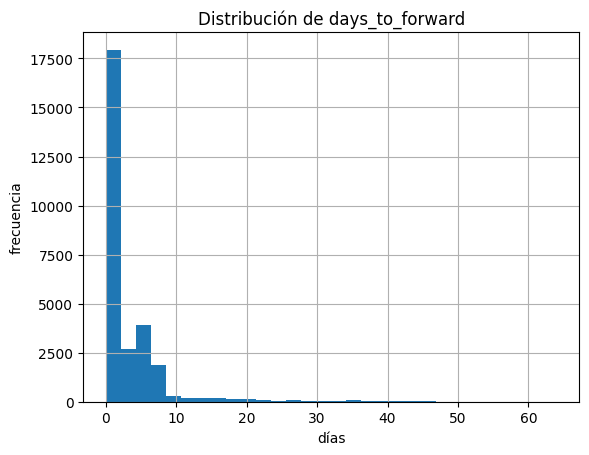

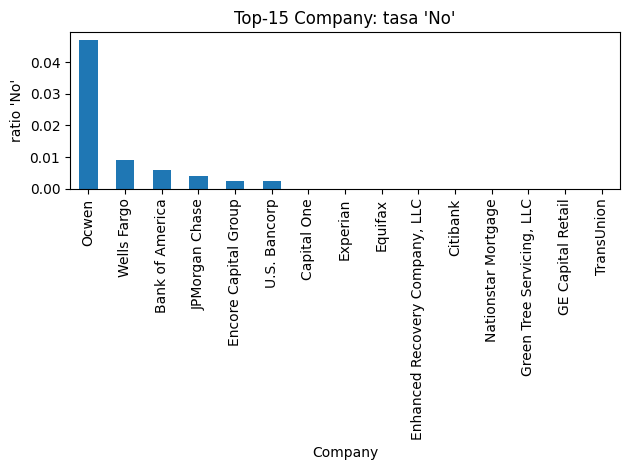

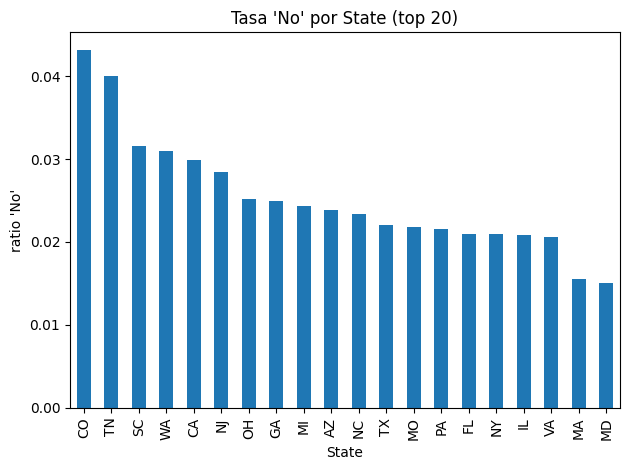

In [23]:

import matplotlib.pyplot as plt

# 1) Histograma days_to_forward (matplotlib, plot único, sin colores específicos)
plt.figure()
df["days_to_forward"].dropna().astype(float).clip(-30, 90).hist(bins=30)
plt.title("Distribución de days_to_forward")
plt.xlabel("días"); plt.ylabel("frecuencia"); plt.show()

# 2) Top-15 empresas por conteo y tasa de 'No'
plt.figure()
top_companies = df["Company"].astype("string").value_counts().head(15).index
tmp = df[df["Company"].isin(top_companies)].copy()
rate_no = tmp.groupby("Company")["y"].apply(lambda s: 1 - s.mean()).sort_values(ascending=False)
rate_no.plot(kind="bar")
plt.title("Top-15 Company: tasa 'No'"); plt.ylabel("ratio 'No'"); plt.tight_layout(); plt.show()

# 3) Tasa 'No' por State (top 20 por volumen)
plt.figure()
top_states = df["State"].astype("string").value_counts().head(20).index
tmp = df[df["State"].isin(top_states)].copy()
rate_no_state = tmp.groupby("State")["y"].apply(lambda s: 1 - s.mean()).sort_values(ascending=False)
rate_no_state.plot(kind="bar")
plt.title("Tasa 'No' por State (top 20)"); plt.ylabel("ratio 'No'"); plt.tight_layout(); plt.show()


### Guardar dataset limpio para modelado

In [26]:
out_clean = Path("data/processed/clean_for_model.csv")
out_clean.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_clean, index=False)
print("Guardado:", out_clean.resolve(), "| Filas:", len(df))


Guardado: C:\Users\abela\Downloads\final\Proyecto_timely_response_CLEAN\notebooks\data\processed\clean_for_model.csv | Filas: 28156
